# CDMS Match Up Demo
Cloud-based Data Matchup Service (CDMS) allows users to collocate satellite to in situ and satellite to satellite data. 

In this notebook, the in situ data subsetting and match-up features will be demonstrated.

In [61]:
import requests
import json
import pandas as pd
import geopandas as gpd
from urllib.parse import urljoin, urlencode

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D

### List available satellite and in situ datasets

In [62]:
response = requests.get("https://doms.jpl.nasa.gov/list").json()
pd.set_option('display.max_colwidth', None)
df = pd.DataFrame(response)[['title', 'iso_start', 'iso_end']]
df.sort_values('title')

,title,iso_start,iso_end
0,ASCATB-L2-Coastal,2015-06-30T23:51:00+0000,2019-01-01T00:02:58+0000
1,JPL-L4-MRVA-CHLA-GLOB-v3.0,2017-01-01T12:00:00+0000,2018-12-31T12:00:00+0000
2,MUR25-JPL-L4-GLOB-v04.2,2017-01-01T09:00:00+0000,2018-12-31T09:00:00+0000
3,OISSS_L4_multimission_7day_v1,2016-12-31T00:00:00+0000,2019-01-02T00:00:00+0000
4,SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL1812,1992-10-02T12:00:00+0000,2019-01-24T12:00:00+0000
5,SMAP_JPL_L3_SSS_CAP_8DAY-RUNNINGMEAN_V5,2016-12-28T12:00:00+0000,2019-01-04T12:00:00+0000
6,VIIRS_NPP-JPL-L2P-v2016.2,2017-01-01T23:30:01+0000,2018-12-31T23:54:01+0000


In [63]:
in_situ_list = []
# manually add in situ metadata to list 
in_situ_list.append({"title": "ICOADS Release 3.0", "iso_start": "2017-01-01T00:00:00+0000","iso_end": "2018-12-31T23:59:59+0000"})
in_situ_list.append({"title": "SAMOS", "iso_start": "2017-01-01T00:00:00+0000","iso_end": "2018-12-31T23:59:59+0000"})
in_situ_list.append({"title": "1021_atlantic", "iso_start": "2019-01-30T01:00:00+0000","iso_end": "2019-10-16T16:00:00+0000"})
in_situ_list.append({"title": "antarctic_circumnavigation_2019", "iso_start": "2019-01-19T00:00:00+0000","iso_end": "2020-08-15T00:00:00+0000"})
in_situ_list.append({"title": "atlantic_to_med_2019_to_2020", "iso_start": "2019-10-18T10:12:00+0000","iso_end": "2020-07-17T13:45:00+0000"})
in_situ_list.append({"title": "shark-2018", "iso_start": "2018-03-15T20:00:00+0000","iso_end": "2018-06-17T00:00:00+0000"})

insitu_df = pd.DataFrame(in_situ_list)[['title', 'iso_start', 'iso_end']]
insitu_df

,title,iso_start,iso_end
0,ICOADS Release 3.0,2017-01-01T00:00:00+0000,2018-12-31T23:59:59+0000
1,SAMOS,2017-01-01T00:00:00+0000,2018-12-31T23:59:59+0000
2,1021_atlantic,2019-01-30T01:00:00+0000,2019-10-16T16:00:00+0000
3,antarctic_circumnavigation_2019,2019-01-19T00:00:00+0000,2020-08-15T00:00:00+0000
4,atlantic_to_med_2019_to_2020,2019-10-18T10:12:00+0000,2020-07-17T13:45:00+0000
5,shark-2018,2018-03-15T20:00:00+0000,2018-06-17T00:00:00+0000


### Subset in situ dataset and plot

In [64]:
query_params = {
    'provider': 'Saildrone',
    'project': 'shark-2018',
    'startTime': '2018-04-01T00:00:00Z',
    'endTime': '2018-04-07T23:59:59Z',
    'bbox': '-180,-90,180,90',
    'platform': '3B',
    'minDepth': -5,
    'maxDepth': 5,
    'variable': 'mass_concentration_of_chlorophyll_in_sea_water',
    'columns': 'mass_concentration_of_chlorophyll_in_sea_water',
    'startIndex': 0,
    'itemsPerPage': 15000
}

In [65]:
in_situ_url = 'https://doms.jpl.nasa.gov/insitu/1.0/query_data_doms'
full_in_situ_url = f'{in_situ_url}?{urlencode(query_params)}'
print(full_in_situ_url)
response = requests.get(full_in_situ_url).json()
print(f'Total number of points returned {response["total"]}')
insitu_df = pd.DataFrame(response["results"])
insitu_df.head() # show first few records

https://doms.jpl.nasa.gov/insitu/1.0/query_data_doms?provider=Saildrone&project=shark-2018&startTime=2018-04-01T00%3A00%3A00Z&endTime=2018-04-07T23%3A59%3A59Z&bbox=-180%2C-90%2C180%2C90&platform=3B&minDepth=-5&maxDepth=5&variable=mass_concentration_of_chlorophyll_in_sea_water&columns=mass_concentration_of_chlorophyll_in_sea_water&startIndex=0&itemsPerPage=15000
Total number of points returned 10052


,mass_concentration_of_chlorophyll_in_sea_water,time,depth,latitude,longitude
0,0.09,2018-04-01T00:00:00Z,0.5,27.240928,-130.020352
1,0.09,2018-04-01T00:01:00Z,0.5,27.240611,-130.020339
2,0.09,2018-04-01T00:02:00Z,0.5,27.240314,-130.020326
3,0.09,2018-04-01T00:03:00Z,0.5,27.240077,-130.020326
4,0.10,2018-04-01T00:04:00Z,0.5,27.239830,-130.020301


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

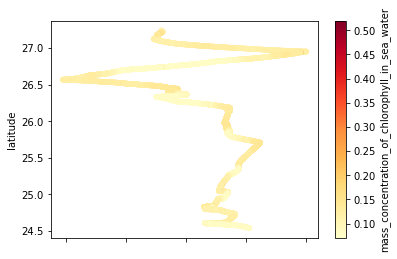

In [66]:
# Simple plot of data
insitu_df.plot(x='longitude', y='latitude', kind='scatter', c='mass_concentration_of_chlorophyll_in_sea_water', colormap='YlOrRd')


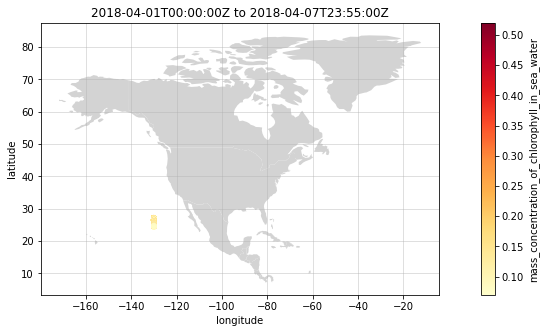

In [67]:
# Plot with a map 

# initialize an axis
fig, ax = plt.subplots(figsize=(15,5))

# plot map on axis
countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#print(countries)
countries[countries['continent'] == 'North America'].plot(color='lightgrey', ax=ax)

# parse dates for plot's title
first = insitu_df['time'].min()
last = insitu_df['time'].max()

# plot points
insitu_df.plot(x='longitude', y='latitude', kind='scatter', 
        c='mass_concentration_of_chlorophyll_in_sea_water', colormap='YlOrRd', 
        title=f'{first} to {last}', 
        ax=ax)

# add grid
ax.grid(alpha=0.5)
plt.show()


### Run satellite to in situ matchup query

In [26]:
matchup_url = 'https://doms.jpl.nasa.gov/match_spark'

In [32]:
def execute_matchup_request(query_params, in_situ_variable_name):
    full_matchup_url = f'{matchup_url}?{urlencode(query_params)}'
    print(full_matchup_url)
    
    response = requests.get(full_matchup_url)
    response = response.json()
    
    primary_points = []
    secondary_points = []
    for primary_point in response['data']:
        for variable in primary_point['matches'][0]['secondary']:
            if variable['variable_name'] == in_situ_variable_name:
                primary_points.append((float(primary_point['lon']), float(primary_point['lat']), float(primary_point['primary'][0]['variable_value'])))
                secondary_points.append((float(primary_point['matches'][0]['lon']), float(primary_point['matches'][0]['lat']), float(variable['variable_value'])))
    print(f'Total number of satellite matched points {len(primary_points)}')
    print(f'Total number of in situ matched points {len(secondary_points)}')
    return primary_points, secondary_points

In [54]:
query_params = {
    'primary': 'JPL-L4-MRVA-CHLA-GLOB-v3.0',
    'secondary': 'shark-2018',
    'startTime': '2018-04-01T00:00:00Z',
    'endTime': '2018-04-01T23:59:59Z',
    'tt': 86400,  # Time tolerance
    'rt': 50000,  # Spatial tolerance
    'b': '-140,10,-110,40',
    'platforms': '3B',
    'depthMin': -5,
    'depthMax': 5,
    'matchOnce': 'true',
    'resultSizeLimit': 100
}

In [55]:
primary_points, secondary_points = execute_matchup_request(query_params, "mass_concentration_of_chlorophyll_in_sea_water")

https://doms.jpl.nasa.gov/match_spark?primary=JPL-L4-MRVA-CHLA-GLOB-v3.0&secondary=shark-2018&startTime=2018-04-01T00%3A00%3A00Z&endTime=2018-04-01T23%3A59%3A59Z&tt=86400&rt=50000&b=-140%2C10%2C-110%2C40&platforms=3B&depthMin=-5&depthMax=5&matchOnce=true&resultSizeLimit=100
Total number of satellite matched points 6
Total number of in situ matched points 6


In [56]:
def plot_points(primary_points, secondary_points):
    plt.figure(figsize=(20,5), dpi=500) 
    min_lon = min([point[0] for point in primary_points])
    max_lon = max([point[0] for point in primary_points])
    min_lat = min([point[1] for point in primary_points])
    max_lat = min([point[1] for point in primary_points])
    basemap = Basemap(
        projection='mill',
        lon_0=180,
        llcrnrlat=min_lat - 50,
        urcrnrlat=max_lat + 50,
        llcrnrlon=min_lon - 50,
        urcrnrlon=max_lon + 50
    )
    basemap.drawlsmask(
        land_color='lightgrey',
        ocean_color='white',
        lakes=True
    )

    # transform coordinates
    x1, y1 = basemap([point[0] for point in primary_points], [point[1] for point in primary_points])  
    x2, y2 = basemap([point[0] for point in secondary_points], [point[1] for point in secondary_points])
    
    # Draw scatter points
    plt.scatter(x2, y2, 10, marker='o', color='Blue', label='Primary point')
    plt.scatter(x1, y1, 10, marker='*', color='Green', label='Secondary point')

    # transform input bbox
    bx, by = basemap([-140, -110], [40, 10])  
    
    # Draw user provided bounds
    plt.gca().add_patch(patches.Rectangle(
        (bx[0], by[1]), abs(bx[0] - bx[1]), abs(by[0] - by[1]), 
        linewidth=1, 
        edgecolor='r', 
        facecolor='none'
    ))
    
    # Show legend
    handles, labels = plt.gca().get_legend_handles_labels()
    bbox_legend = Line2D(
        [0], [0], 
        color='red', 
        linewidth=1, 
        linestyle='-', 
        label='User search domain'
    )
    handles.append(bbox_legend)
    plt.legend(loc='upper left', handles=handles)
    
    plt.show()

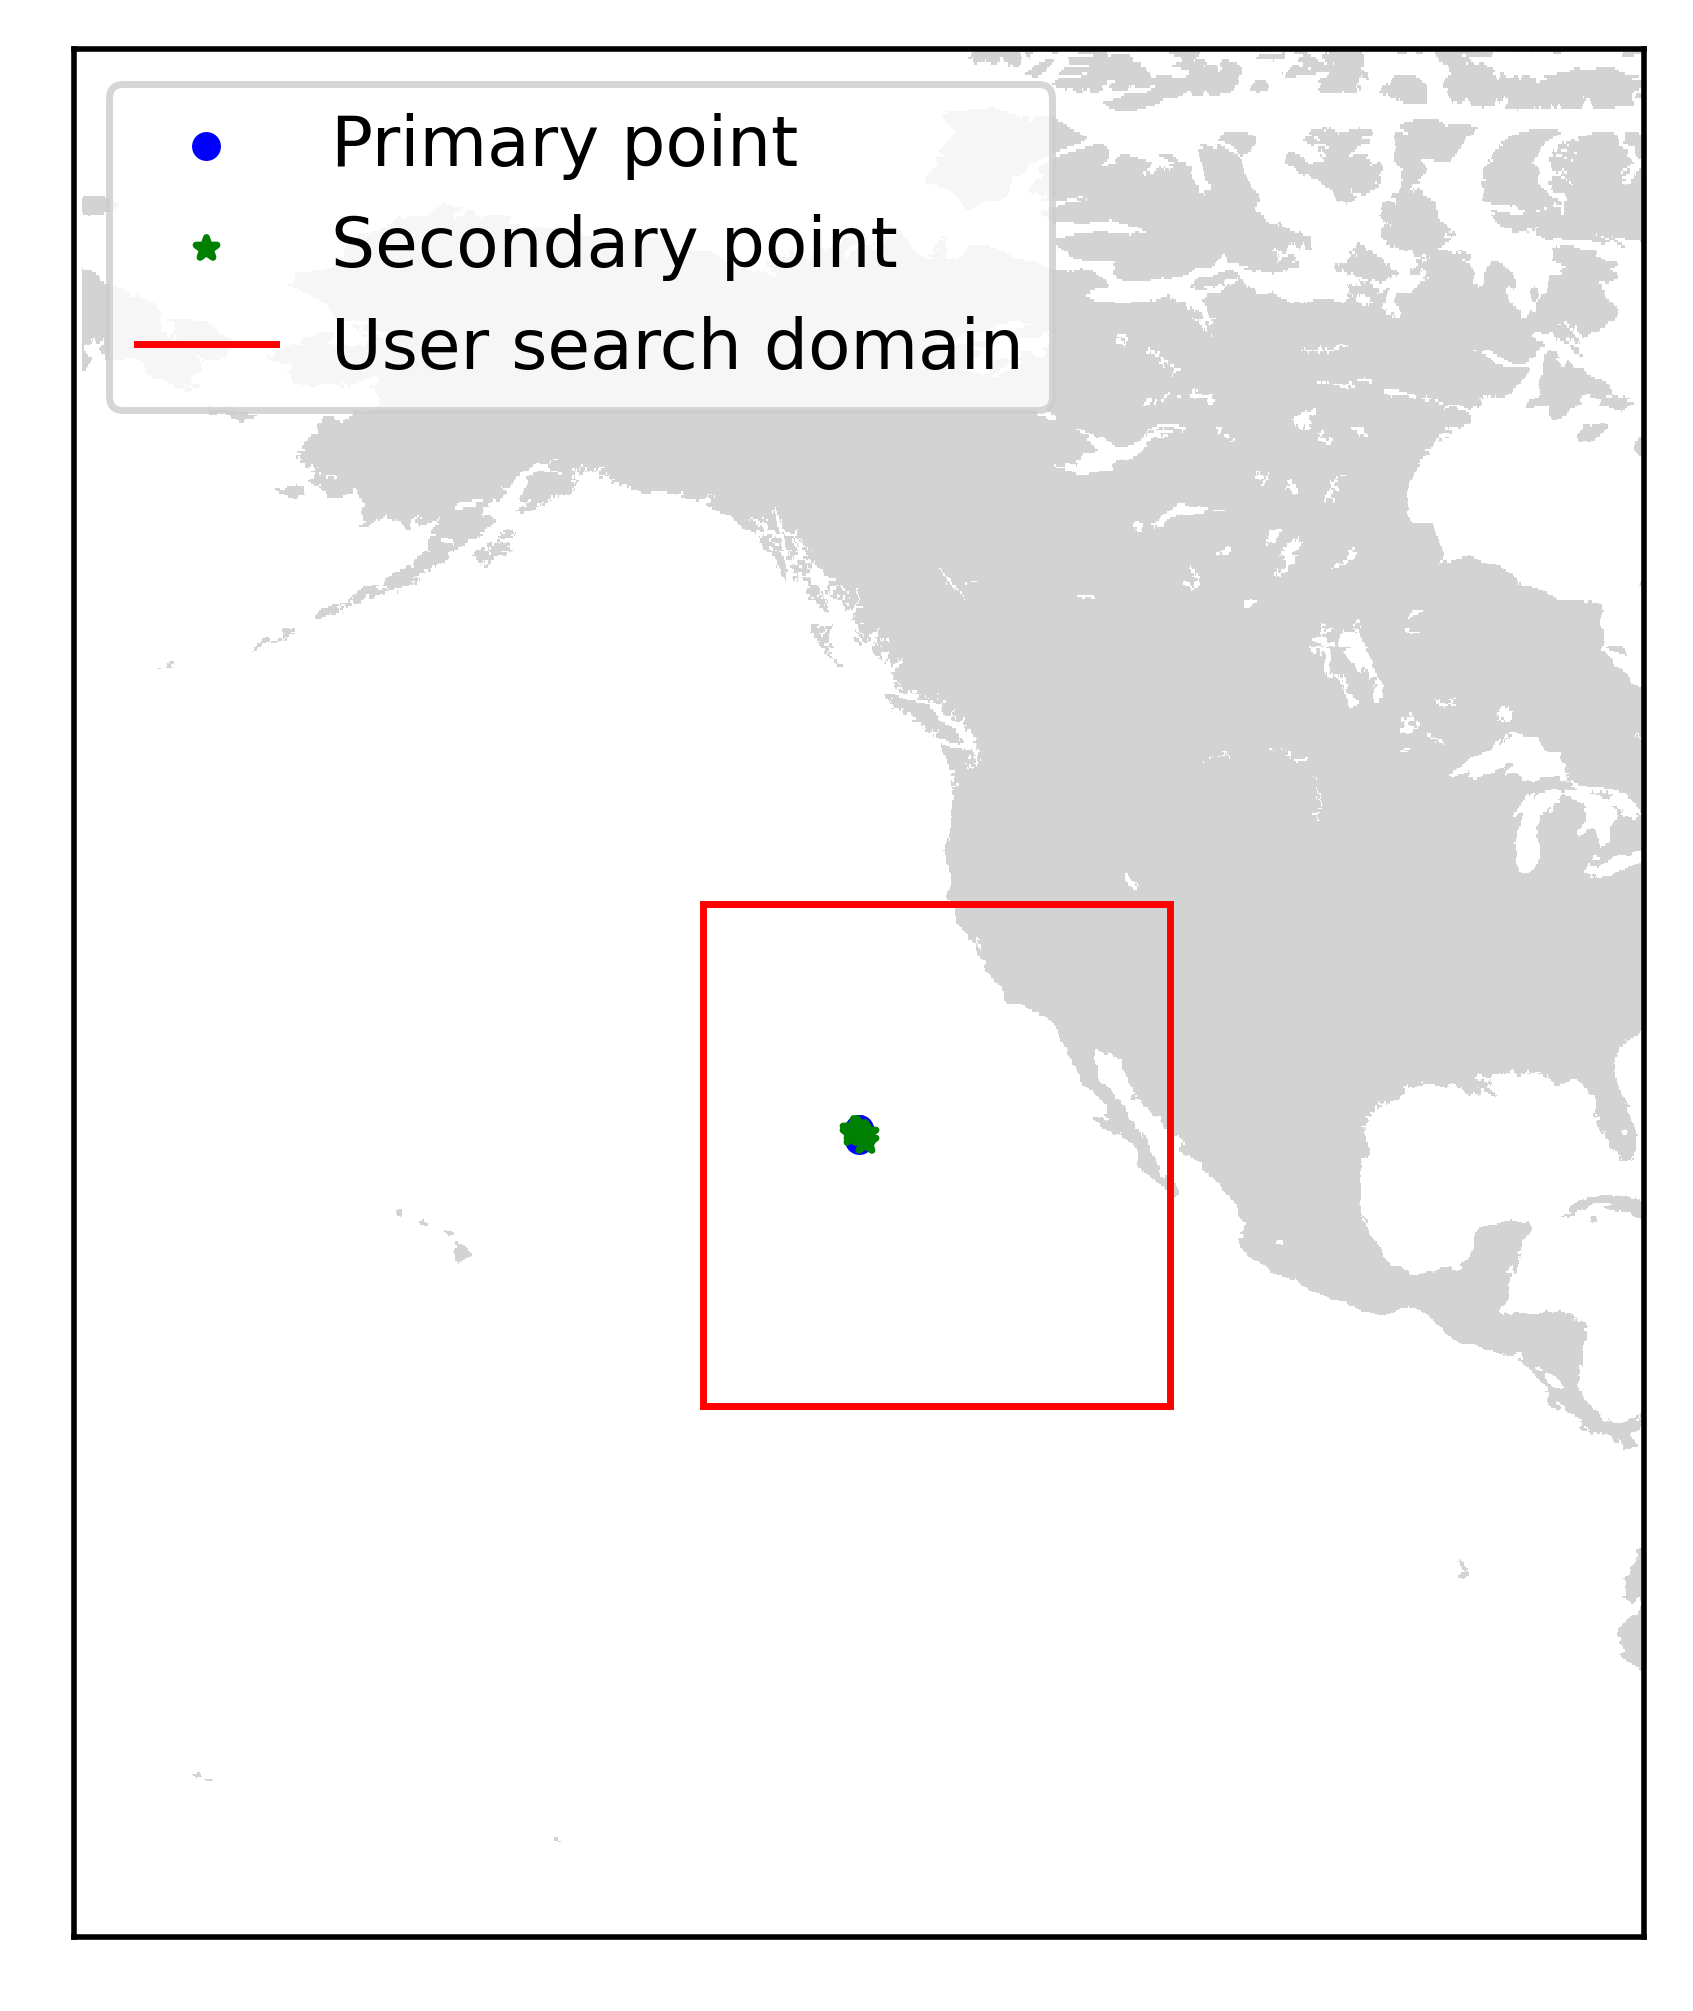

In [57]:
plot_points(primary_points, secondary_points)

In [58]:
def generate_diff_plot(primary_points, secondary_points, primary_name, secondary_name, units):
    diffs = [primary_point[2] - secondary_point[2] for primary_point, secondary_point in zip(primary_points, secondary_points)]
    
    plt.figure(figsize=(20,5), dpi=500) 
    min_lon = min([point[0] for point in primary_points])
    max_lon = max([point[0] for point in primary_points])
    min_lat = min([point[1] for point in primary_points])
    max_lat = min([point[1] for point in primary_points])
    basemap = Basemap(
        projection='mill',
        lon_0=180,
        llcrnrlat=min_lat - 10,
        urcrnrlat=max_lat + 10,
        llcrnrlon=min_lon - 10,
        urcrnrlon=max_lon + 10
    )
    basemap.drawlsmask(
        land_color='lightgrey',
        ocean_color='white',
        lakes=True
    )

    # transform coordinates
    x1, y1 = basemap([point[0] for point in primary_points], [point[1] for point in primary_points])  
    x2, y2 = basemap([point[0] for point in secondary_points], [point[1] for point in secondary_points])
    
    # Customize colormap/colorbar
    cmap = plt.cm.coolwarm
    # Draw scatter points
    sc = plt.scatter(x2, y2, 30, marker='o', c=diffs, alpha=0.7, cmap=cmap)

    cb = plt.colorbar(sc)
    cb.ax.set_title(units,fontsize=8)        
    plt.title(f'Difference plot between {primary_name} and {secondary_name}')

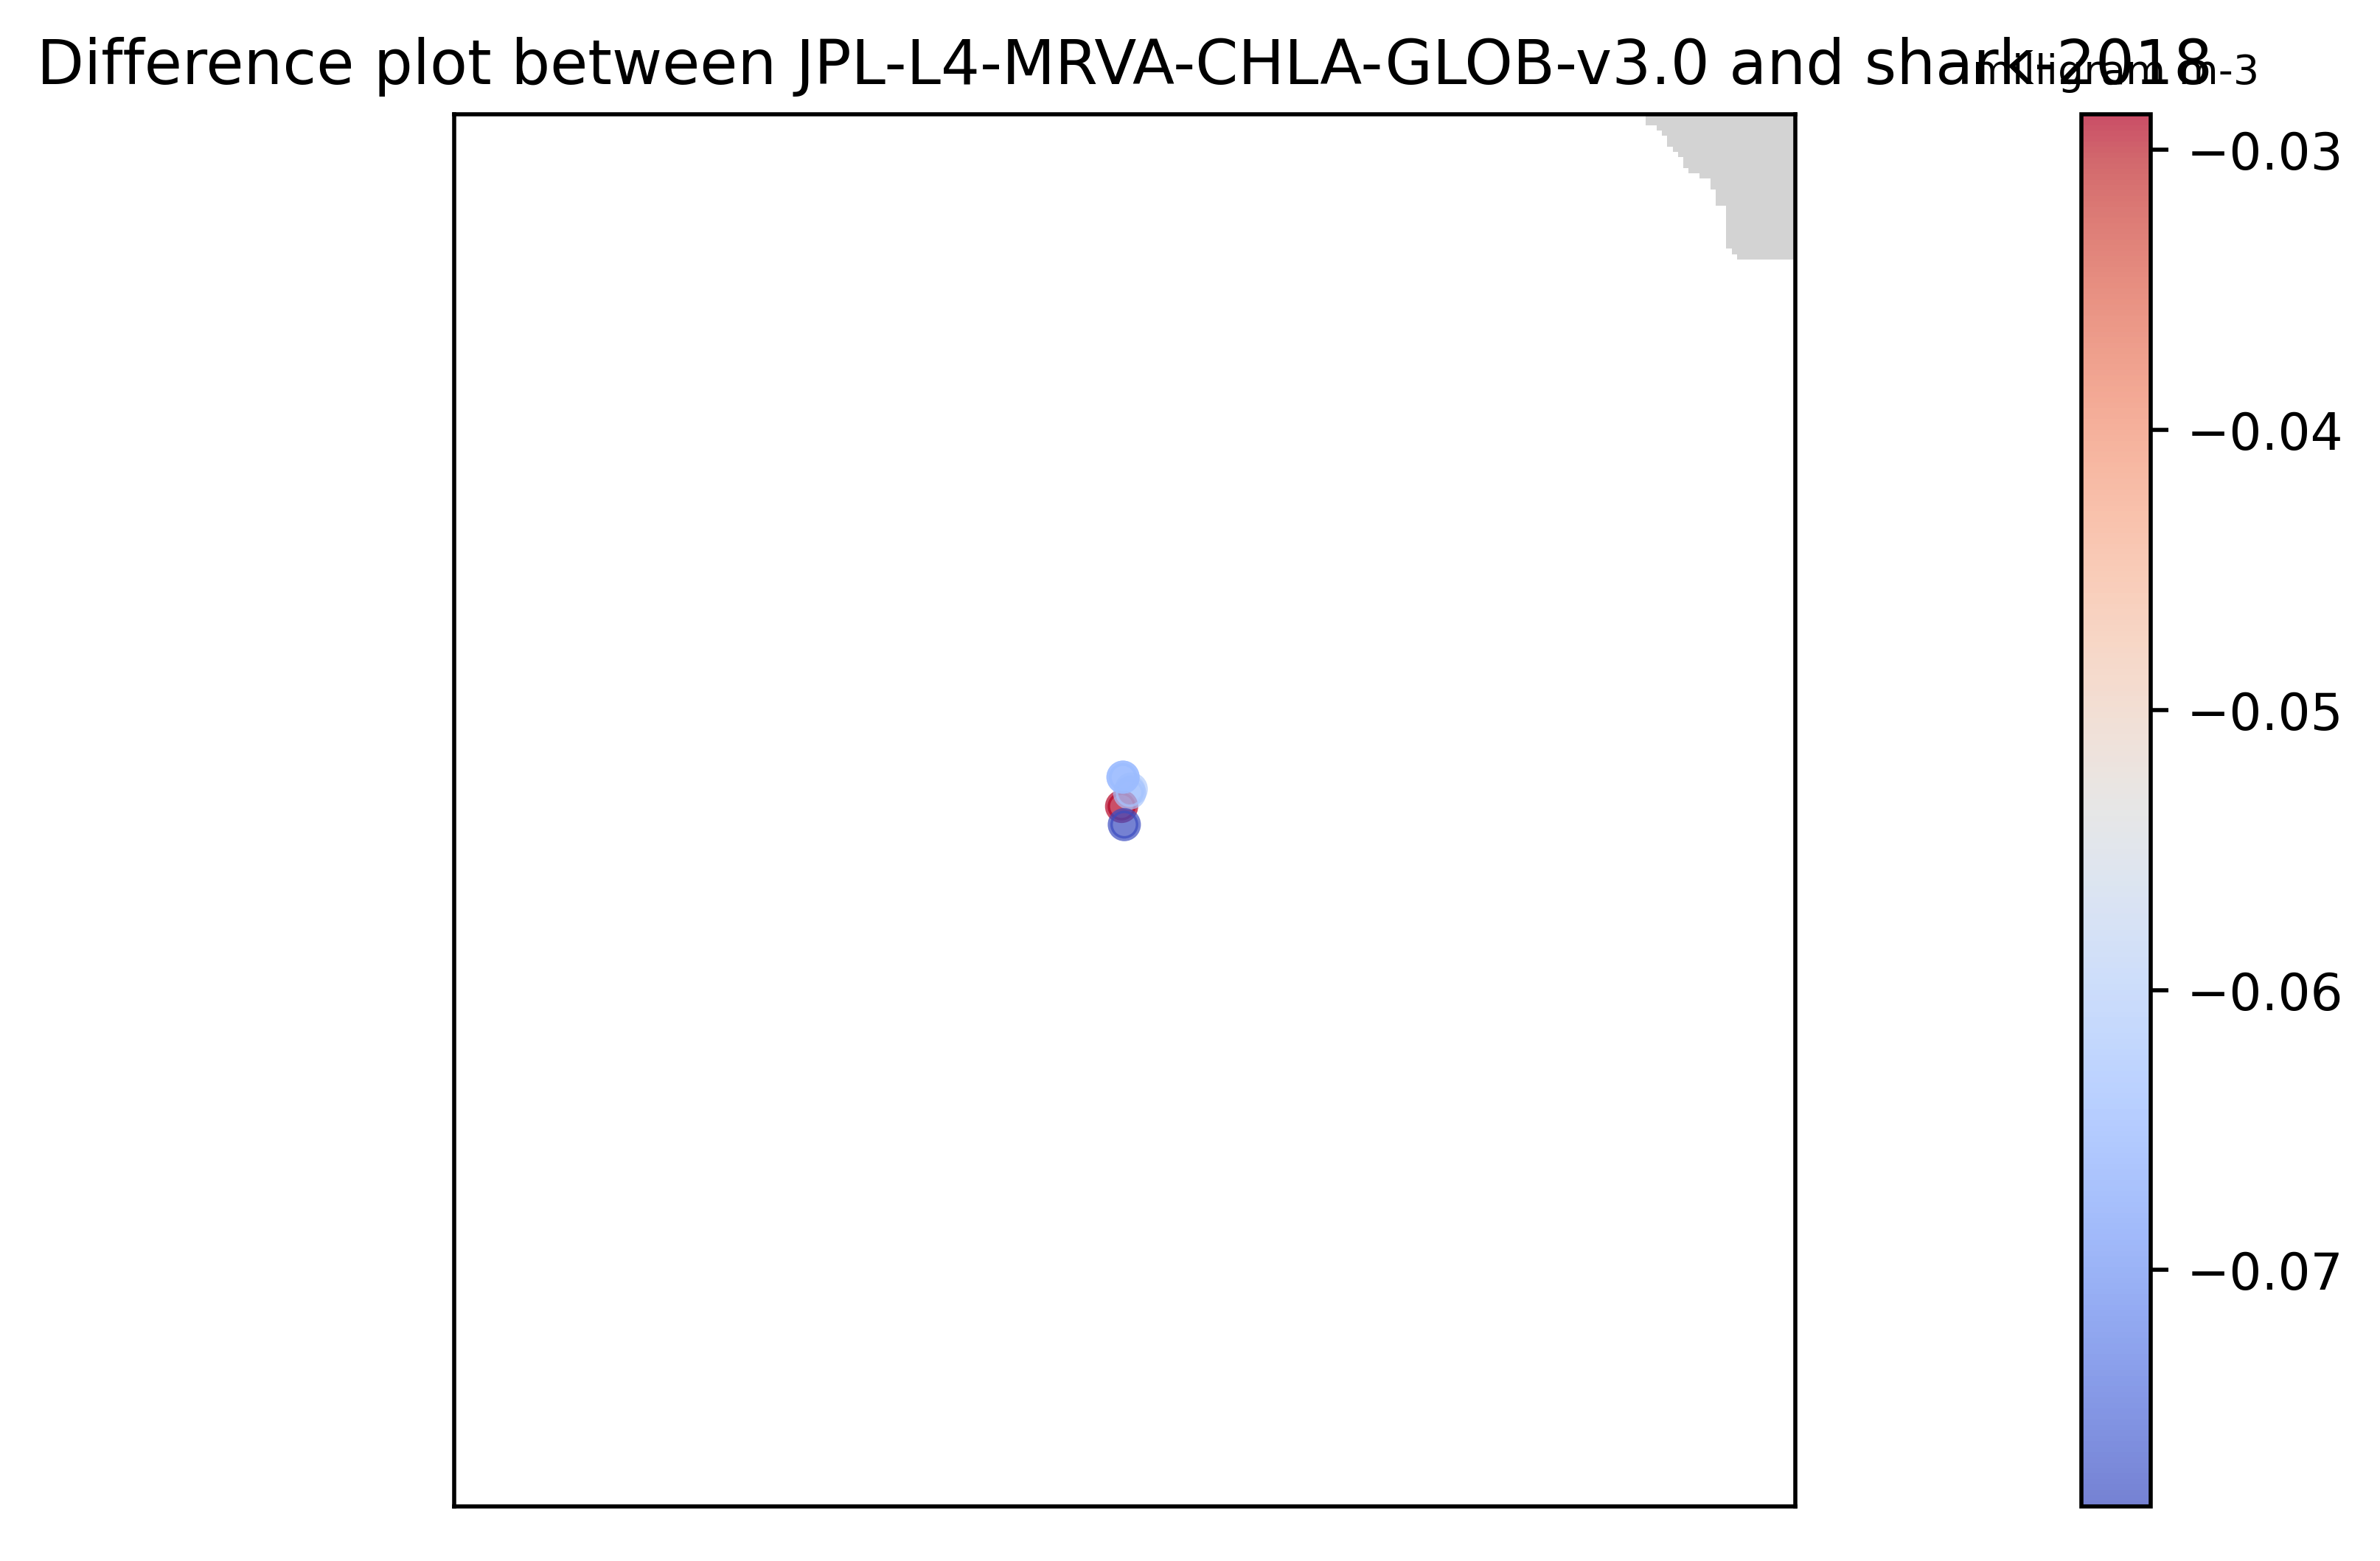

In [59]:
generate_diff_plot(primary_points, secondary_points, query_params['primary'], query_params['secondary'], 'milligram m-3')

https://doms.jpl.nasa.gov/match_spark?primary=MUR25-JPL-L4-GLOB-v04.2&secondary=shark-2018&startTime=2018-04-01T00%3A00%3A00Z&endTime=2018-04-02T23%3A59%3A59Z&tt=86400&rt=50000&b=-140%2C10%2C-110%2C40&platforms=3B&depthMin=-5&depthMax=5&matchOnce=true&resultSizeLimit=100
Total number of satellite matched points 46
Total number of in situ matched points 46


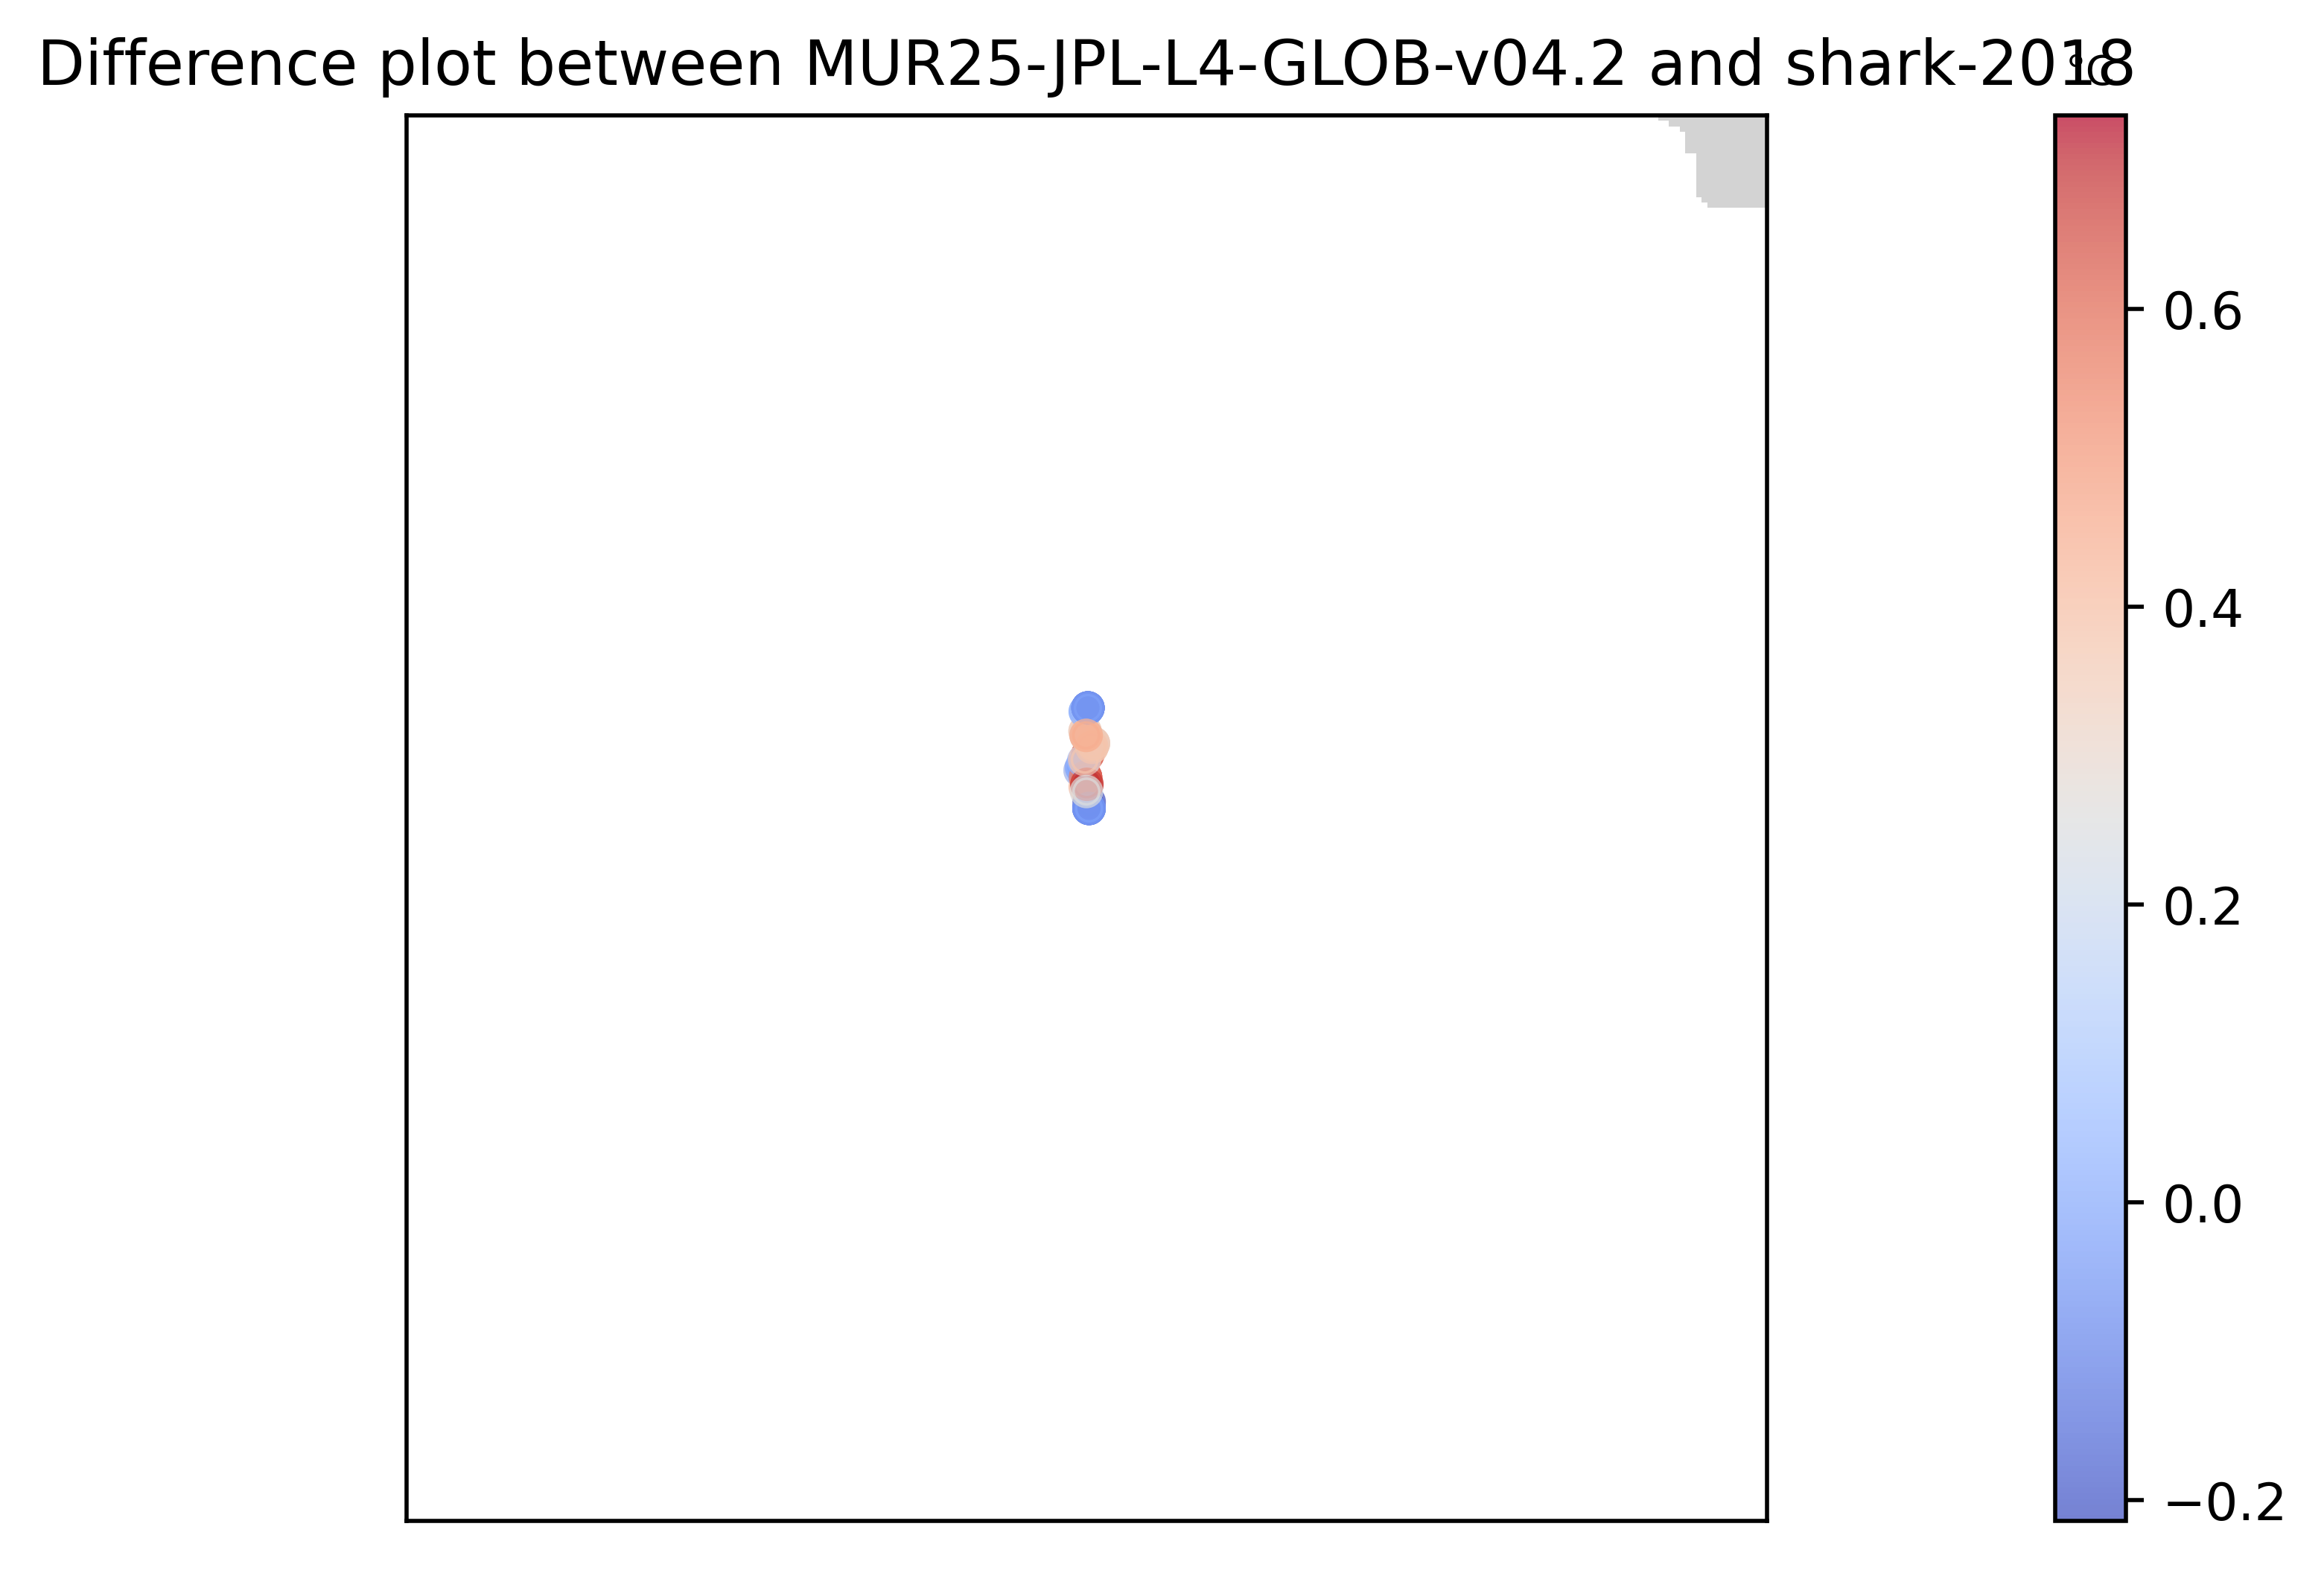

In [60]:
query_params = {
    'primary': 'MUR25-JPL-L4-GLOB-v04.2',
    'secondary': 'shark-2018',
    'startTime': '2018-04-01T00:00:00Z',
    'endTime': '2018-04-02T23:59:59Z',
    'tt': 86400,  # Time tolerance
    'rt': 50000,  # Spatial tolerance
    'b': '-140,10,-110,40',
    'platforms': '3B',
    'depthMin': -5,
    'depthMax': 5,
    'matchOnce': 'true',
    'resultSizeLimit': 100
}

primary_points, secondary_points = execute_matchup_request(query_params, "sea_water_temperature")
generate_diff_plot(primary_points, secondary_points, query_params['primary'], query_params['secondary'], '°C')